## Import python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium as fl
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings; warnings.simplefilter('ignore')
from my_func import *

In [2]:
# Read the csv file into the dataframe
df = pd.read_csv('./dsc-v2-mod1-final-project-dc-ds-career-042219/kc_house_data.csv')

## King County Map

In [3]:
map = fl.Map(location=[df['lat'].mean(), df['long'].mean()])
map

#### Using histograms to see all columns

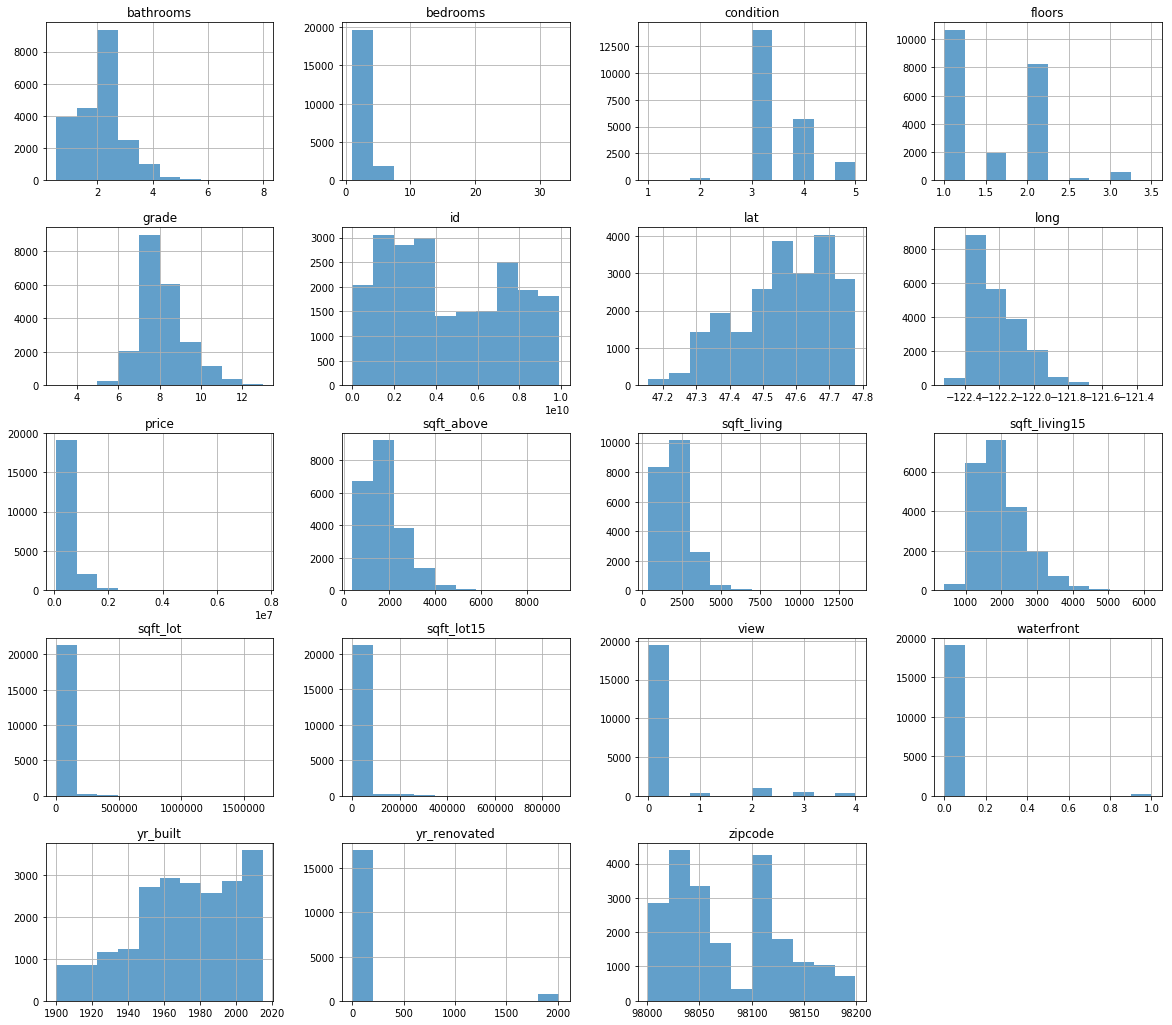

In [4]:
df.hist(alpha=0.7, figsize=(20,18));

#### Scatter plot columns against target variable price


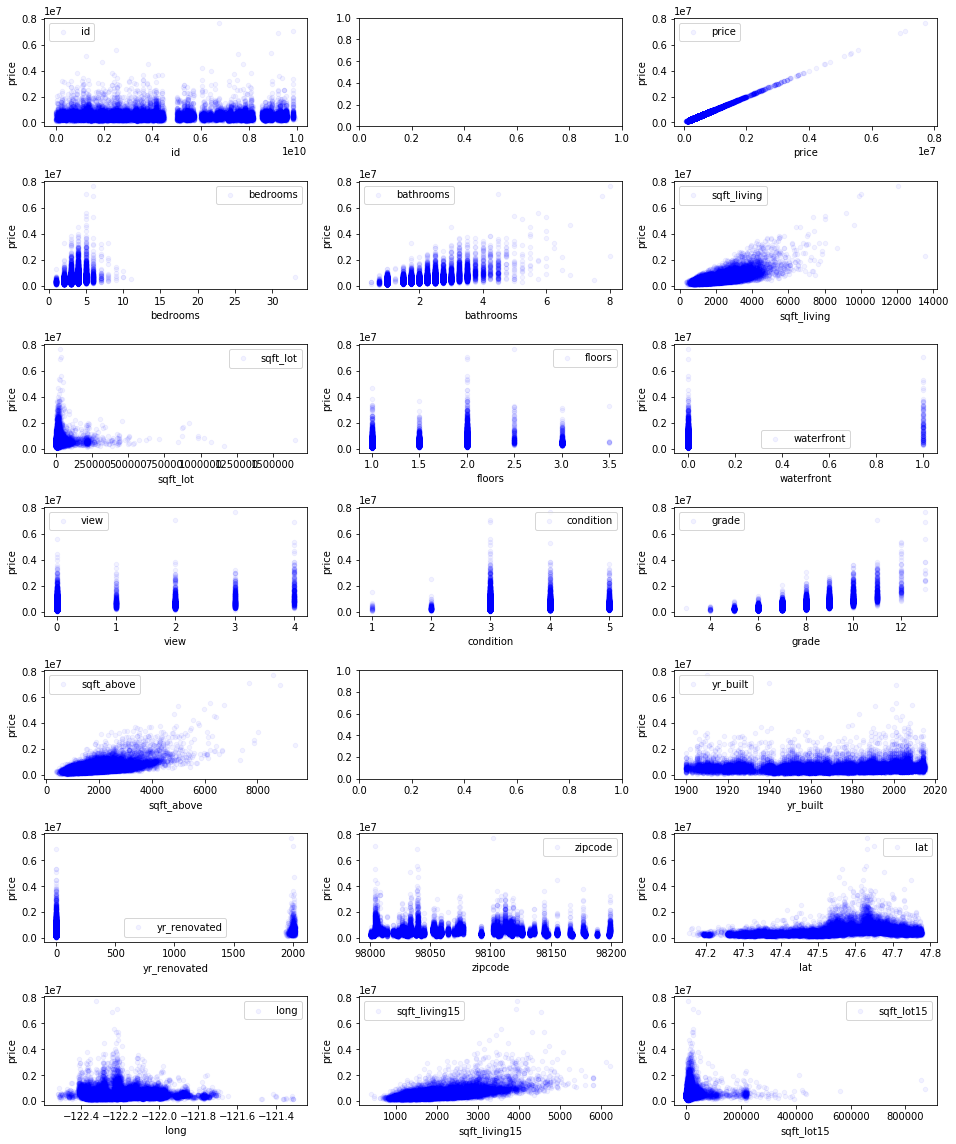

In [5]:
scatter_y(df, 'price', ncols=3, figsize=(16, 20), wspace=0.2, hspace=0.5, alpha=0.05, color='b')

#### SF Living vs Price

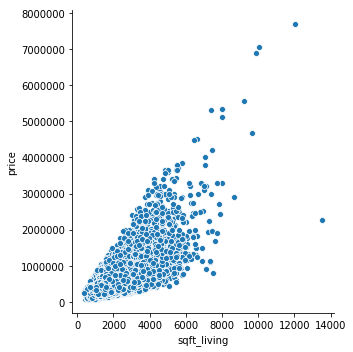

In [6]:
sns.relplot(x="sqft_living", y="price", data=df);

#### SF Living 15 vs Price

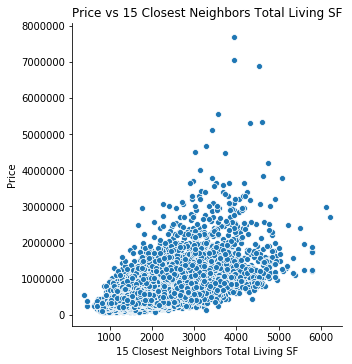

In [7]:
ax = sns.relplot(x="sqft_living15", y="price", data=df);
ax.set(xlabel="15 Closest Neighbors Total Living SF", ylabel="Price", title="Price vs 15 Closest Neighbors Total Living SF");


### Data cleaning 

### Our model concentrates on houses worth $1 million or less

In [8]:
df = df[df['price'] <= 1000000]

### Droping columns 

#### id, lat, long, yr_built, and waterfront columns are dropped as they are not used in our model

In [9]:
df.drop(['id', 'lat', 'long','yr_built', 'waterfront'], axis=1, inplace=True)

##### Create year and month columns from date column and then drop date 

In [10]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.drop('date', axis=1, inplace=True)

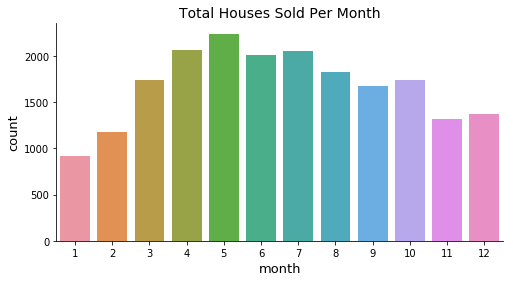

In [11]:
sns_context()
f, ax = plt.subplots(figsize=(8,4))
sns.countplot('month', data=df);
ax.set_title('Total Houses Sold Per Month')
sns.despine()


### Imputing missing values 

##### sqft basement is just sqft living minus sqft above 

In [12]:
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = \
df.loc[df['sqft_basement'] == '?', 'sqft_living']  \
- df.loc[df['sqft_basement'] == '?', 'sqft_above'] 
df['sqft_basement'] = df['sqft_basement'].astype(float)

##### filled 63 rows of view with 0 instead of NAN

In [14]:
df['view'].fillna(0.0, inplace=True)

##### filled 3577 rows of year renovated with 0's 

In [15]:
df['yr_renovated'].fillna(0.0, inplace=True)

### Feature engineering - dummying variables 

##### King county sends home inspectors every 6 years and homes are assessed scores for grade, condition, and view are given. We created two  buckets for yr_renovated, split before and after 2010. 

In [16]:
df.loc[df['yr_renovated'] < 2010.0, 'yr_renovated'] = 0.0
df.loc[df['yr_renovated'] >= 2010.0, 'yr_renovated'] = 1.0


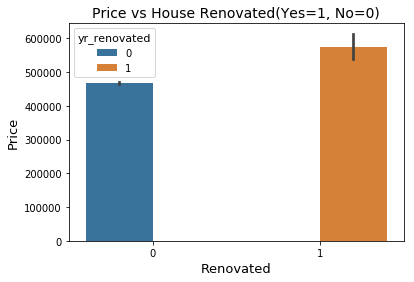

In [17]:
df['yr_renovated'] = df['yr_renovated'].astype(int)
ax=sns.barplot(x="yr_renovated", y="price", data=df, hue='yr_renovated', saturation=0.65);
ax.set(xlabel='Renovated', ylabel='Price', title='Price vs House Renovated(Yes=1, No=0)');


##### Dummy out all categorical variables 

In [18]:
df_dm = pd.get_dummies(data = df, columns=['month', 'year', 'condition', 'grade','zipcode'])

##### Standardizing variables to have similar units to compare 

In [19]:
sc = StandardScaler() ## initialize standard scaler object 

### Visualizations 

#### Condition vs Price

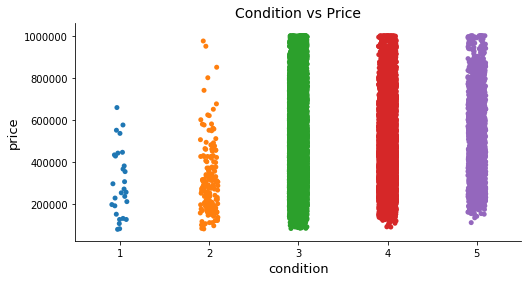

In [20]:
sns_stripplot('condition', 'price', "Condition vs Price", df)

#### Grade vs Price

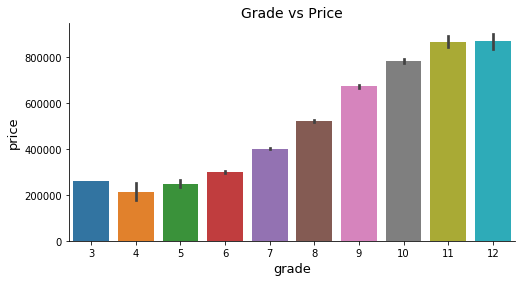

In [21]:
sns_barplot('grade', 'price', 'Grade vs Price', df)

#### View vs Price

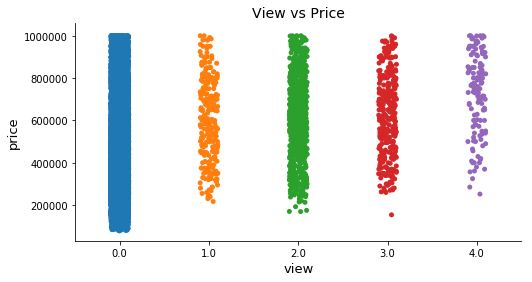

In [22]:
sns_stripplot('view', 'price', 'View vs Price', df)

### Train/Test split 

In [23]:
X = df_dm.drop(['price'], axis =1) ## drop target variable from indep. variables 
y = df_dm['price'] ## price is the target variable

In [24]:
X_train, X_test, y_train, y_test = split_train_test(X, y)

In [25]:
X_train_std = sc.fit_transform(X_train)

In [26]:
X_test_std = sc.transform(X_test)

#### Making sure that the OLS model labels the coefficients with column name

In [27]:
X_train_std_df = pd.DataFrame(X_train_std, columns = df_dm.columns[1:])

In [28]:
X_test_std_df = pd.DataFrame(X_test_std, columns = df_dm.columns[1:])

### Modeling 

#### ordinary least square regression model

In [29]:
y_train_drop_ind = y_train.reset_index(drop=True)

In [30]:
predictors_int = sm.add_constant(X_train_std_df)
model = sm.OLS(y_train_drop_ind, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     786.5
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        11:15:41   Log-Likelihood:            -2.0474e+05
No. Observations:               16111   AIC:                         4.097e+05
Df Residuals:                   16007   BIC:                         4.105e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.688e+05    632.080    741.694      0.000    4.68e+05     4.7e+05
bedrooms      -1095.2304    828.585     -1.322      0.186   -2719.349     528.888
bathrooms      6050.0898   1052.213      5.750      0.000    3987.634    8112.545
sqft_living    4.042e+04    727.160     55.581      0.000     3.9e+04    4.18e+04
sqft_lot       1.218e+04    886.299     13.742      0.000    1.04e+04    1.39e+04
floors        -1.233e+04    959.397    -12.848      0.000   -1.42e+04   -1.04e+04
view           2.029e+04    687.247     29.526      0.000    1.89e+04    2.16e+04
sqft_above     4.005e+04    760.903     52.634      0.000    3.86e+04    4.15e+04
sqft_basement  4612.2854    711.274      6.485      0.000    3218.109    6006.462
yr_renovated   6138.1490    638.406      9.615      0.000    4886.802    7389.496
sqft_living15  1.931e+04   1111.840     17.364      0.000    1.71e+04    2.15e+04
sqft_lot15     -508.3490    919.691     -0.553      0.580   -2311.046    1294.348
month_1       -6688.3442    857.374     -7.801      0.000   -8368.894   -5007.794
month_2       -5568.8282    904.835     -6.155      0.000   -7342.406   -3795.251
month_3       -2749.3044    995.543     -2.762      0.006   -4700.681    -797.928
month_4         162.5246   1048.001      0.155      0.877   -1891.676    2216.725
month_5         205.6497    570.514      0.360      0.719    -912.622    1323.921
month_6        3135.9133    707.931      4.430      0.000    1748.290    4523.537
month_7        1950.1018    709.419      2.749      0.006     559.561    3340.643
month_8        2496.1420    704.062      3.545      0.000    1116.101    3876.183
month_9        1245.7168    696.333      1.789      0.074    -119.174    2610.608
month_10       1203.2026    698.658      1.722      0.085    -166.246    2572.651
month_11        507.3998    685.159      0.741      0.459    -835.588    1850.387
month_12       1259.7591    687.057      1.834      0.067     -86.949    2606.467
year_2014     -8863.2023   1004.196     -8.826      0.000   -1.08e+04   -6894.865
year_2015      8863.2023   1004.196      8.826      0.000    6894.865    1.08e+04
condition_1   -3238.5082    638.760     -5.070      0.000   -4490.550   -1986.466
condition_2   -3512.5313    630.400     -5.572      0.000   -4748.186   -2276.876
condition_3   -8072.9120    387.547    -20.831      0.000   -8832.547   -7313.277
condition_4    3085.6216    420.310      7.341      0.000    2261.767    3909.476
condition_5    1.105e+04    563.667     19.608      0.000    9947.808    1.22e+04
grade_3        5.512e-12   6.18e-13      8.922      0.000     4.3e-12    6.72e-12
grade_4       -1473.3430    638.553     -2.307      0.021   -2724.978    -221.708
grade_5       -6659.3896    656.022    -10.151      0.000   -7945.266   -5373.513
grade_6       -1.555e+04    692.856    -22.442   

In [31]:
model.mse_total ** 0.5

196878.5202369386

#### Parameters that impact the house sale price the most

In [32]:
model.params.sort_values(ascending=False)

const            468810.170815
sqft_living       40416.369324
sqft_above        40049.160403
zipcode_98103     27688.782924
zipcode_98004     27667.225925
zipcode_98115     26016.986206
zipcode_98117     24625.539708
zipcode_98112     21898.110209
grade_9           21278.539034
zipcode_98199     20398.684459
zipcode_98040     20333.156457
view              20291.377655
zipcode_98119     20058.004866
zipcode_98105     19422.794052
sqft_living15     19305.461172
zipcode_98107     18904.097090
grade_10          18696.947427
zipcode_98033     18317.862876
zipcode_98122     17761.124067
zipcode_98109     16499.729266
zipcode_98116     16480.159083
zipcode_98102     14642.603952
zipcode_98006     13655.652122
zipcode_98052     13520.133061
zipcode_98005     12823.231834
sqft_lot          12179.822721
condition_5       11052.658517
grade_11           9852.630556
zipcode_98136      9780.793665
zipcode_98144      9240.285472
                     ...      
zipcode_98166     -6082.359408
grade_5 

##### Predict on unseen data 

In [33]:
predictors_test = sm.add_constant(X_test_std_df)
y_predict = model.predict(predictors_test)

##### Get R^2 

In [34]:
score = r2_result(y_test, y_predict)
print('\n R^2 Score {}'.format(score))


 R^2 Score 0.8244606445076959
